# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [22]:
%pylab inline
#%matplotlib inline
import datacube
import ogr
import xarray as xr
from datacube.storage import masking
import pandas
from matplotlib import pyplot as plt
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py2-env/20160726/envs/agdc/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [23]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [24]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [25]:
#dc.list_measurements()

In [26]:
#Use this if you want to specify a shapefile
#open shapefile and retrieve extents
'''vec_fname = '/g/data/r78/lxl554/hovmoller/Murray Mouth.shp'
vec_ds = ogr.Open(vec_fname)
layer = vec_ds.GetLayer(0)
extent = layer.GetExtent()
print "Extent: {}".format(extent)

lat_max = extent[3]
lat_min = extent[2]
lon_max = extent[1]
lon_min = extent[0]'''

'vec_fname = \'/g/data/r78/lxl554/hovmoller/Murray Mouth.shp\'\nvec_ds = ogr.Open(vec_fname)\nlayer = vec_ds.GetLayer(0)\nextent = layer.GetExtent()\nprint "Extent: {}".format(extent)\n\nlat_max = extent[3]\nlat_min = extent[2]\nlon_max = extent[1]\nlon_min = extent[0]'

## Retrieve surface reflectance data


In [27]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Define spatial range

lat_max = -30.59
lat_min = -30.62
lon_max = 150.13
lon_min = 150.19


#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-01-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'


In [ ]:
#load sensor specific band adjustment tuples for TSS and brightness

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [28]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')

sensor1_pq = dc.load(product= sensor1+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')
            

In [29]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [30]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [31]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    sensor1_rsindex['TSS'] = ((sensor1_nbar['green']+sensor1_nbar['red'])/2)

In [32]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor2_pq = dc.load(product= sensor2+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')
                   

In [33]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [34]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [35]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    sensor2_rsindex['TSS'] = ((sensor2_nbar['green']+sensor2_nbar['red'])/2)

In [36]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor3_pq = dc.load(product= sensor3+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')

In [37]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [38]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [39]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    #sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)

## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [40]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean_sorted = nbar_clean.isel(time=time_sorted)

all_tss = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss.time.argsort()
all_tss_sorted = all_tss.isel(time=time_sorted)

all_ndvi = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi.time.argsort()
all_ndvi_sorted = all_ndvi.isel(time=time_sorted)

The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

In [41]:
'''#Calculate the size of the xarray the query has retrieved
def calculate_size(bytes, gb=False):
    size = bytes / 1024.0 / 1024.0
    if gb: 
        return size / 1024.0
    return size
print "Array size in Gb:{}".format(calculate_size(nbar_clean_sorted.nbytes, True))
VDIram = 12
RAMpercent = ((calculate_size(nbar_clean_sorted.nbytes, True)/VDIram)*100)
print "Selected array is " +str(RAMpercent)+ " percent of available RAM"'''

'#Calculate the size of the xarray the query has retrieved\ndef calculate_size(bytes, gb=False):\n    size = bytes / 1024.0 / 1024.0\n    if gb: \n        return size / 1024.0\n    return size\nprint "Array size in Gb:{}".format(calculate_size(nbar_clean_sorted.nbytes, True))\nVDIram = 12\nRAMpercent = ((calculate_size(nbar_clean_sorted.nbytes, True)/VDIram)*100)\nprint "Selected array is " +str(RAMpercent)+ " percent of available RAM"'

<xarray.DataArray 'time' ()>
numpy.datetime64('2015-03-31T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2015-03-31
Attributes:
    units: seconds since 1970-01-01 00:00:00


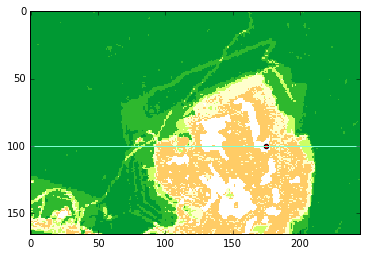

In [50]:
#Define coordinates of interest
xdim = 175
ydim = 100
time_slice = 1000
tss_min = 0
tss_max = 2000
fig, figsize=(11.69,8.27)
plt.scatter(x=[xdim], y=[ydim], c='r')
plt.plot([0, all_ndvi_sorted.shape[2]], [ydim,ydim], 'aquamarine')
ndvi_cmap = mpl.colors.ListedColormap(['#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])

ndvi_bounds = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
tss_bounds = [0, 500,1000, 1500, 2000, 2500, 3000]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
plt.imshow(all_ndvi_sorted[time_slice], interpolation = 'nearest',  cmap = ndvi_cmap, norm = ndvi_norm)
print all_ndvi_sorted[time_slice].time


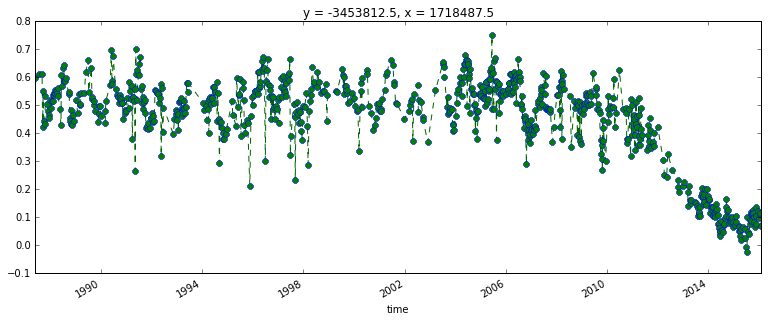

In [51]:
fig = plt.figure(figsize=(13,5))
#all_tss_sorted.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'darkgreen', marker = '8', mec = 'b', mfc ='g')
all_ndvi_sorted.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'darkgreen', marker = '8', mec = 'b', mfc ='g')

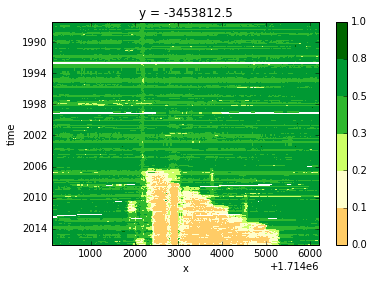

In [53]:
#View as a Hovmoller plot for the y axis)
all_ndvi_sorted.isel(#x=[xdim],
                     y=[ydim]
                     ).plot(norm= ndvi_norm, cmap = ndvi_cmap, yincrease = False)
#plt.plot([0, all_ndvi_sorted.shape[2]], [time_slice,time_slice], 'r')

In [ ]:
fig = plt.figure(figsize=(11.69,8.27))

water_only = all_tss_sorted.where(nbar_clean_sorted['swir1']<1000)
water_only.isel(x=[xdim],
                     #y=[ydim]
                     ).plot(cmap = tss_cmap, norm = tss_norm, yincrease = False)
land_only = all_ndvi_sorted.where(nbar_clean_sorted['swir1']>1000)
land_only.isel(x=[xdim],
                     #y=[ydim]
                     ).plot(cmap = ndvi_cmap, norm = ndvi_norm, yincrease = False)

In [ ]:
print water_only.shape
all_ndvi_sorted.i

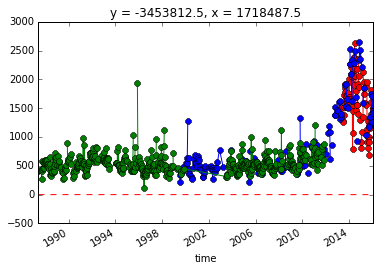

In [56]:
all_ndvi_sorted.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r')
sensor1_rsindex['TSS'].isel(x=[xdim],y=[ydim]).plot(c = 'r', marker = '8')
sensor2_rsindex['TSS'].isel(x=[xdim],y=[ydim]).plot(c  = 'b', marker = '8')
sensor3_rsindex['TSS'].isel(x=[xdim],y=[ydim]).plot(c = 'g', marker = '8')


## Some basic band maths
We can combine the `red` and `nir` (_near-infrared_) bands to calculate NDVI (_normalised difference vegetation index_).

## Pixel drill

In [ ]:
nbar_sorted['red'].isel(x=[10], y=[10]).plot()
nbar_clean_sorted['red'].isel(x=[10], y=[10]).plot()

In [ ]:
nbar_clean_sorted['nir'].isel(y=15).plot()


## Plotting a multi-band image

In [57]:
rgb = dc.load(product= sensor1+'_nbar_albers', 
              x=(lon_min, lon_max), y=(lat_max, lat_min), 
              time = (start_of_epoch, end_of_epoch), 
              measurements=['swir1', 'nir', 'green'], 
              group_by='solar_day', stack='color',
              #dask_chunks={'time':1, 'x': 1000, 'y': 1000} 
              ).transpose('time', 'y', 'x', 'color')
            

zip(rgb.dims, rgb.shape)

[('time', 119), ('y', 166), ('x', 245), ('color', 3)]

In [58]:
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [59]:
rgb.shape[2]

245

IndexError: index 1000 is out of bounds for axis 0 with size 119

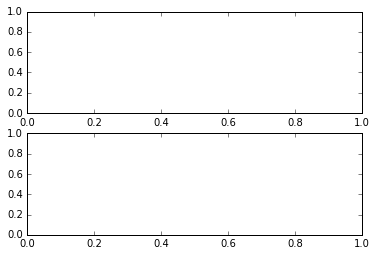

In [61]:

fig, axes = subplots(nrows=2)
axes[0].imshow(scaled.isel(time = time_slice), interpolation = 'nearest')
axes[0].plot(y=[(25,25)], x=[(0, rgb.shape[2])], color='r-')
axes[0].axis('image')

In [ ]:
#Shows syntax for multi panel plot
'''from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 11
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(ndvi_acca.isel(time = t), cmap = 'viridis')
axes[0,1].set_title('ACCA')
axes[1,0].imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')
axes[1,0].set_title('Fmask')
axes[1,1].imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')
axes[1,1].set_title('Saturated')'''
#tight_layout()

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 3
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(acca_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[0,1].set_title('ACCA')
axes[1,0].imshow(fmask_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,0].set_title('Fmask')
axes[1,1].imshow(saturation_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,1].set_title('Saturated')
#tight_layout()'''

In [ ]:
#fig,  figsize=(11.69,8.27)


saturation_good_data.sum('time').plot()

In [ ]:
acca_good_data.sum('time').plot()

In [ ]:
plt.imshow(ndvi_acca.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')